# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [2]:
import numpy as np


class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented

In [155]:
class Input(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0} # initialization 
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
        

In [156]:

class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W


In [157]:

        


class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value   # [0] input is a list
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [9]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

losses = []
# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10    # hidden layer node number
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 1000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 169.322
Epoch: 101, Loss: 5.435
Epoch: 201, Loss: 4.929
Epoch: 301, Loss: 4.293
Epoch: 401, Loss: 3.831
Epoch: 501, Loss: 3.457
Epoch: 601, Loss: 3.987
Epoch: 701, Loss: 3.456
Epoch: 801, Loss: 3.712
Epoch: 901, Loss: 3.393


### 2. 回答一下理论题目

#### 1. What does a neuron compute?

neuron compute 多个神经元通过输入信号X乘以权重W加上偏移量b，然后通过激活函数得到输出神经元
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$  
 sigmoid函数只是激活函数其中一种

####  2. Why we use non-linear activation funcitons in neural networks?

如果使用线性的激活函数，无论多深的神经网络，都可以用wx+b来替代，都相当于一层的神经网络，
这样多层的神经网络就失去了意义

#### 3. What is the 'Logistic Loss' ?

Logistic Loss为逻辑回归的损失函数，一般为对数损失函数（二分类）
$$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

Answer：C

#### 5. Why we don't use zero initialization for all parameters ?

导致每个节点计算的w都是一样的，以致于一个神经元与n个神经元是一样的
w不能初始化为零，b可以为零，一般初始化为一个比较小的值，
因为sigmoid或者其他激活函数，当初始化太大，进行迭代由于倒数仅仅于1，会导致迭代不动

#### 6. Can you implement the softmax function using python ? 

$$S_j = \frac{e^ {a_j}}{\sum_{k=1}^k e^ {a_k}}$$

In [4]:
import numpy as np
def softmax(x):
    x-=np.max(x)
    return np.exp(x)/np.sum(np.exp(x),axis=0)

X = [3.0,1.0, 0.2]
print(softmax(X))

[0.8360188  0.11314284 0.05083836]


### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [142]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [143]:
# Loading the data 
digits = datasets.load_digits()

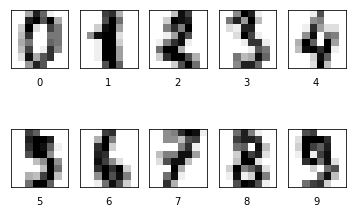

In [144]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [145]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [146]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)


(1347, 64) (1347,) (450, 64) (450,)


In [116]:
X_train = X_train.T
X_test = X_test.T

y_train = y_train.reshape(1,-1)
y_test = y_test.reshape(1,-1)
print("X_train:",X_train.shape,"y_train:",y_train.shape,"X_test:",X_test.shape,"y_test:",y_test.shape)
'''
X_train = X_train.reshape(X_train.shape[0],-1)
y_train = y_train.reshape(y_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
y_test = y_test.reshape(y_test.shape[0],-1)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
'''

X_train: (64, 1347) y_train: (1, 1347) X_test: (64, 450) y_test: (1, 450)


'\nX_train = X_train.reshape(X_train.shape[0],-1)\ny_train = y_train.reshape(y_train.shape[0],-1)\nX_test = X_test.reshape(X_test.shape[0],-1)\ny_test = y_test.reshape(y_test.shape[0],-1)\n\nprint(X_train.shape,y_train.shape,X_test.shape,y_test.shape)\n'

#### 3- Architecture of the neural network

![title](network.png)

In [117]:
!pwd

/Users/YI/Desktop/NLPTravel/Assignment-4


##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [118]:
import numpy as np
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1/(1+np.exp(-z))
    
    return s

In [119]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [120]:
# Random innitialize the parameters

def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    #w = np.random.randn(dim,1)
    w = np.zeros((dim,1))
    b = 0
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

In [121]:
#Test
w,b = initialize_parameters(X_train.shape[0])
print(w.shape,w,b)

(64, 1) [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] 0


#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)})+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [122]:
def propagate(w,b,X,Y,activation_func=sigmoid):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[1]
    A = activation_func(np.dot(w.T,X)+b)
    cost = -1/m * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A) ) 

   
    dw = np.dot(X,(A-Y).T)/m
    db = np.sum(A-Y)/m
    
    #cost = -1/m * np.sum(np.dot(Y,np.log(A)) + np.dot(1-Y,np.log(1-A)) )
    #print("cost:",cost)
    #print("w.T",w.T.shape,"X:",X.shape,"A:",A.shape,"Y",Y.shape)
    #print("dw:",dw.shape,"w:",w.shape)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

In [123]:
propagate(w,b,X_train,y_train)

({'dw': array([[ 0.00000000e+00],
         [ 1.70749814e-02],
         [-3.45211581e-02],
         [-1.29175947e-01],
         [-2.25686711e-01],
         [-7.54639941e-01],
         [-4.72531552e-01],
         [-5.71640683e-02],
         [-3.71195249e-04],
         [ 9.05716407e-02],
         [-4.99628805e-01],
         [ 1.07646622e-02],
         [ 5.91314031e-01],
         [-1.49591685e-01],
         [-3.78990349e-01],
         [-3.37787676e-02],
         [ 1.11358575e-03],
         [-3.82331106e-02],
         [-6.43652561e-01],
         [ 3.86785449e-01],
         [ 9.47661470e-01],
         [ 1.28062361e-01],
         [-1.48478099e-02],
         [ 0.00000000e+00],
         [ 3.71195249e-04],
         [ 6.45879733e-02],
         [-6.50705271e-01],
         [-7.90645880e-01],
         [-1.77060134e-01],
         [-2.75426875e-01],
         [ 1.35857461e-01],
         [ 3.71195249e-04],
         [ 0.00000000e+00],
         [ 3.73051225e-01],
         [-3.73793615e-01],
         [-9.0

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [124]:
def optimize(w, b, X, Y, num_iterations, learning_rate,activation_func=sigmoid,print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w,b,X,Y)
        
        
        dw = grads['dw']
        db = grads['db']
        
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs

In [125]:
#Test
params, grads, costs = optimize(w,b,X_train,y_train,100,0.001)

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [126]:
def predict(w, b, X,activation_func=sigmoid):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))

    w = w.reshape(X.shape[0],1)

    A = activation_func(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        if A[0,i]>0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
            
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

In [127]:
#Test
w_best,b_best = params['w'],params['b']
print(w_best.shape,b_best.shape)
print("X_test:",X_test.shape)
predict(w_best,b_best,X_test)


(64, 1) ()
X_test: (64, 450)


array([[1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
        0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
        0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
        1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 

##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [128]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate,activation_func=sigmoid,print_cost=False):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    # initialize parameters
    w,b = initialize_parameters(X_train.shape[0])
    
    # Gradient descent
    parameters ,grads,costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,activation_func,print_cost)
    
    #best w,b
    best_w = parameters['w']
    best_b = parameters['b']
    
    #prediction
    Y_prediction_test = predict(best_w,best_b,X_test)
    Y_prediction_train = predict(best_w,best_b,X_train)
    
    traing_accuracy = 100 - np.mean(np.abs(Y_prediction_train -Y_train)*100)
    test_accuracy = 100 - np.mean(np.abs(Y_prediction_test -Y_test)*100)
    #traing_accuracy = np.mean(Y_prediction_train)/np.mean(Y_train)
    #test_accuracy = np.mean(Y_prediction_test)/np.mean(Y_test)
    
    d ={
        "w":best_w,
        "b":best_b,
        "training_accuracy": traing_accuracy,
        "test_accuracy":test_accuracy,
        "cost":costs}
    return d

In [129]:
#Test
d = model(X_train,y_train,X_test,y_test,100,0.01,False)
print(d)

{'w': array([[ 0.00000000e+00],
       [-1.08813496e-02],
       [-1.62091965e-03],
       [-2.46329944e-02],
       [ 1.18521526e-02],
       [ 1.14838889e-01],
       [ 1.08483757e-01],
       [ 1.78542102e-02],
       [ 1.35091473e-03],
       [-5.55279224e-02],
       [ 1.04602117e-01],
       [ 2.23563748e-02],
       [-6.75952177e-02],
       [-1.53898855e-02],
       [ 6.34880696e-02],
       [ 8.08168968e-03],
       [-1.03553560e-03],
       [-2.15068405e-02],
       [ 1.44451913e-01],
       [-3.62581676e-02],
       [-2.29719146e-01],
       [-3.37404887e-02],
       [-5.25424185e-02],
       [-5.90457317e-03],
       [-5.99940081e-04],
       [-1.02611510e-01],
       [ 6.58372446e-02],
       [ 2.22486171e-01],
       [ 2.07727903e-02],
       [ 1.02737550e-01],
       [-9.33588373e-02],
       [-4.45458707e-04],
       [ 0.00000000e+00],
       [-1.86928256e-01],
       [ 2.24028598e-02],
       [ 1.80843481e-01],
       [-2.20795099e-02],
       [-3.30862941e-03],
      

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

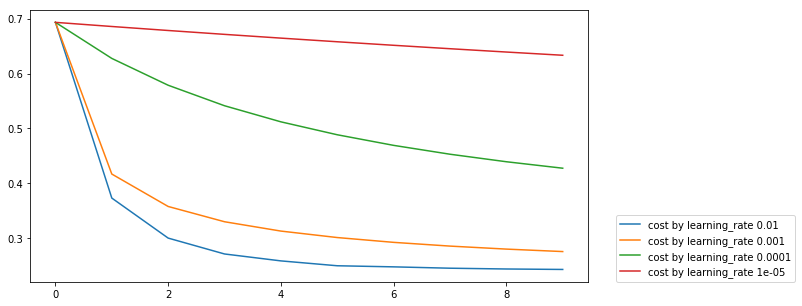

In [130]:
learning_rate = [1e-2,1e-3,1e-4,1e-5]
results = []
plt.figure(figsize=(10,5))

for i in learning_rate:
    result = model(X_train,y_train,X_test,y_test,1000,i,sigmoid,False)
    plt.plot(np.arange(len(result['cost'])),result['cost'],label="cost by learning_rate {}".format(i))
#plt.legend(num1=1.05,num3=3,num4=0)
plt.legend(bbox_to_anchor=(1.05,0), loc=3, borderaxespad=0)
plt.show()


##### 4.2 Observe the effect of iteration_num on the test accuracy.

In [131]:
iteration_num = [200,500,1000,2000,5000,10000]

for i in iteration_num:
    result = model(X_train,y_train,X_test,y_test,i,1e-2,False)
    test_accuracy = result['test_accuracy']
    print("iteration_num {}:".format(i),test_accuracy)



iteration_num 200: 88.44444444444444
iteration_num 500: 88.66666666666667
iteration_num 1000: 89.11111111111111
iteration_num 2000: 88.88888888888889
iteration_num 5000: 89.33333333333333
iteration_num 10000: 89.33333333333333


# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digits (0,1,2,3,4,5,6,7,8,9) is in the image.

In [134]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [136]:
X_train = X_train.T
X_test = X_test.T

y_train = y_train.reshape(1,-1)
y_test = y_test.reshape(1,-1)

In [138]:
def predict(w, b, X,activation_func=softmax):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))

    w = w.reshape(X.shape[0],1)

    A = activation_func(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        Y_prediction[0,i] = A[0,i]          
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

进行中...

# Congratulations ! You have completed assigment 4. 